<a href="https://colab.research.google.com/github/PRIYA-VARSHA/localrepo/blob/main/text_to_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

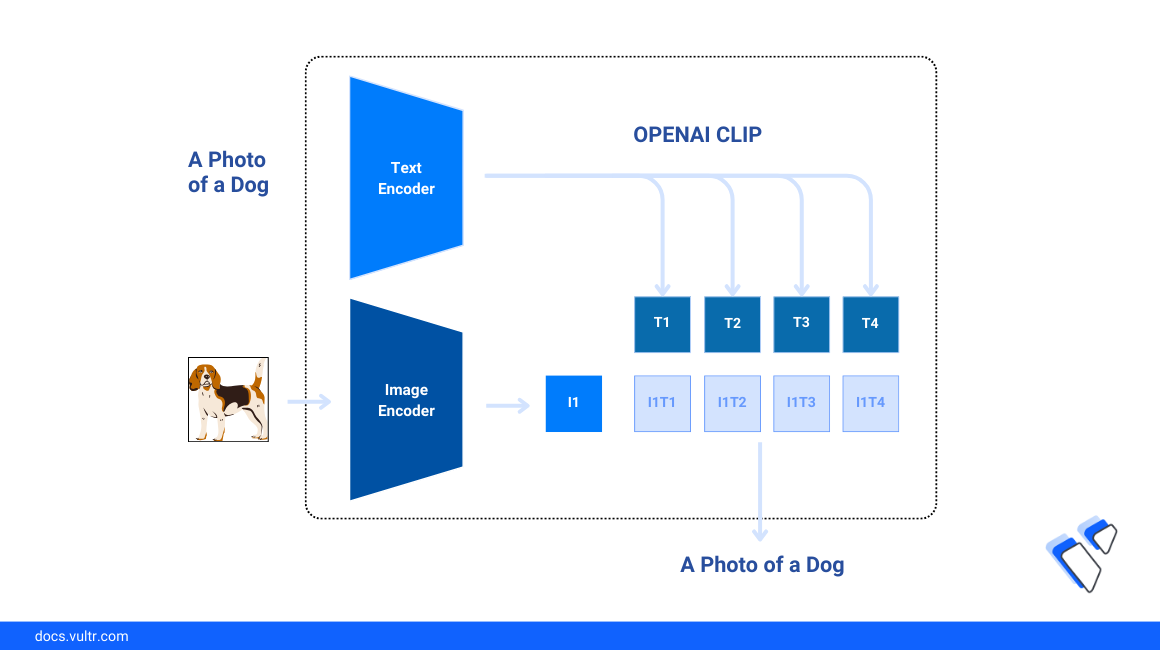

Image classification is a vision recognition approach that involves understanding and categorizing an image according to its visual content. Traditionally, classification involves a supervised learning process that requires careful data preparation and customized model training efforts to achieve results similar to a pre-trained model.

We are trying to install the packages from git CLIP --> Contrastive Language-Image Pretraining and also with this we are also downloading some essential libraries

In [1]:
!pip install git+https://github.com/openai/CLIP.git scikit-image matplotlib

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t2dxgm3u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t2dxgm3u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using c

In [6]:
import torch
import clip
import numpy as np
import skimage
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage import data

The code which loads the CLIP model architecture with the specified configuration. "ViT-B/32" refers to the Vision Transformer (ViT) model with a pixel size of 32. the device comment which says that where the model should be runned with CPU or GPU

In [3]:
device = "cpu" #if you dont have any GPU just mention cpu
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.7MiB/s]


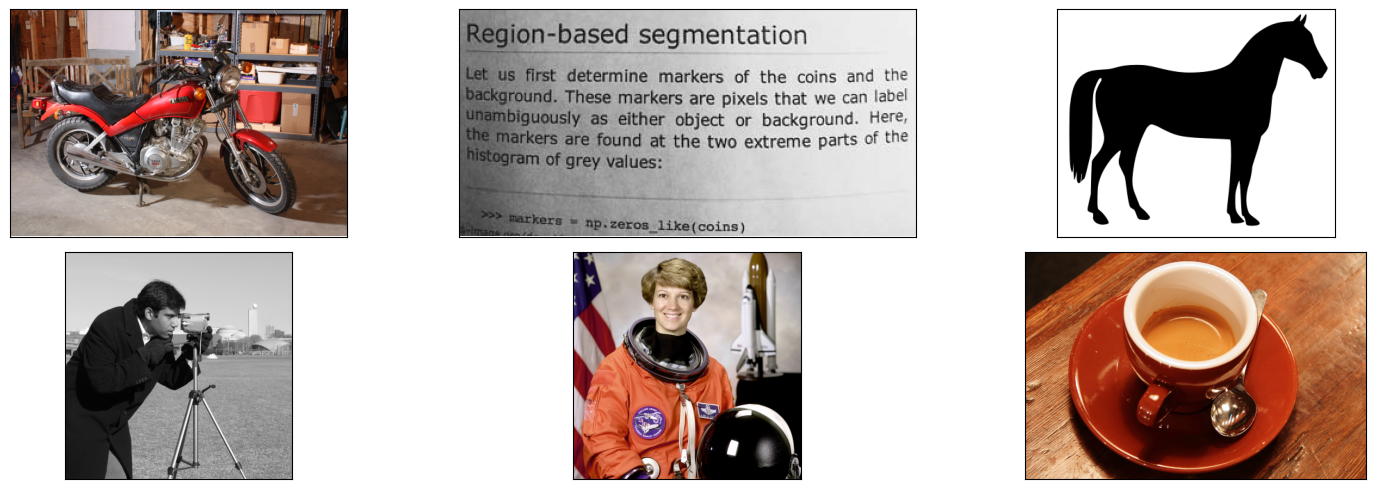

In [17]:
target_classes = ["page", "astronaut", "motorcycle_right", "camera", "horse", "coffee"] #This list contains the names of the target classes or objects you are interested in. These classes will be used to filter the image from the dataset.

original_images = [] #This list will store the original images that belong to the target classes.
image_embeddings = [] #This list will store the embeddings (vector representations) of the images generated by the CLIP model.
plt.figure(figsize=(16, 5))
data_dir = data.__path__[0]
for filename in [filename for filename in os.listdir(data_dir) if filename.endswith(".png")]:
    name = os.path.splitext(filename)[0] #This line extracts the filename without the extension.
    if name not in target_classes:
        continue
    image = Image.open(os.path.join(data_dir, filename)).convert("RGB") #This line opens the image file using PIL(Python Imaging Library) and converts it to RBG format.

    plt.subplot(2, 3, len(image_embeddings) + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    image_embeddings.append(preprocess(image))

plt.tight_layout()
plt.show()

In [18]:
with torch.no_grad():
    image_input = torch.tensor(np.stack(image_embeddings)).to(device) # the list of image embeddings is converted into Numpy Array.
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

Tokenization is the process of breaking the text into individual tokens or words.

In [19]:
with torch.no_grad(): #To disable gradient computation, to ensure that no gradients are calculated within the blocks.
    text_descriptions = [f"This is a photo of a {label}" for label in target_classes] #This line generates text descriptions for each target class. It iterates over "target_classes" and creates a description for each class in the format
    text_tokens = clip.tokenize(text_descriptions).to(device) #this line toxenize the text description using CLIP model's.
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [20]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1) #This line calculates the similarity between the image features and the text features by performing a dot product between the image features and the transposed text feartures. The result is multiplied by 100 to scale the value.
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

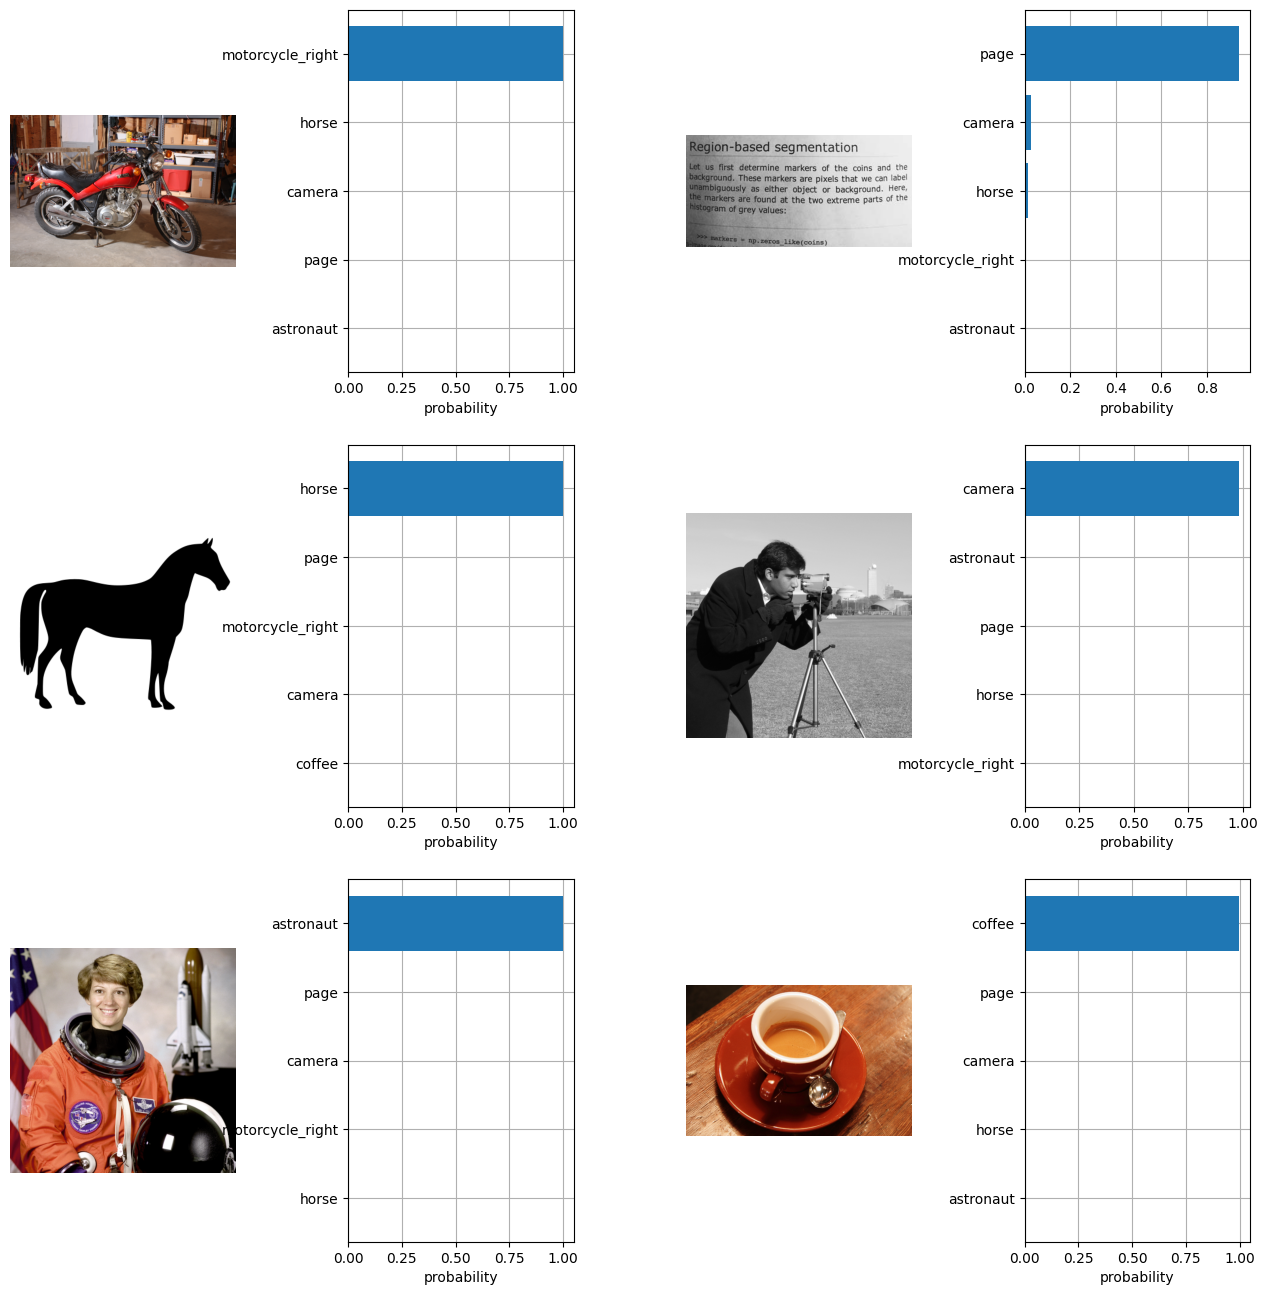

In [21]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(3, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(3, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [target_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()